## Introduction

This notebook presents a demo of [BERT4Rec](https://arxiv.org/pdf/1904.06690) that was introduced in 2019. BERT4Rec aims to address the limitations of the sequence-based recommender systems that model the user's historical interactions unidirectionally (from left to right). To do so, BERT4Rec employs a bidirectional self-attention network. The model is trained using the Cloze objective, where some items are masked randomly, and the model is supposed to predict the ids of masked items with cross-entropy loss. This notebook is based on the [PyTorch implementation](https://github.com/jaywonchung/BERT4Rec-VAE-Pytorch) of BERT4Rec, and consists of the following sections:
1. Data
2. BERT4Rec model
3. Training and testing

<p align="center">
    <img src="https://user-images.githubusercontent.com/16665038/189218683-0d77ba28-ebf8-449f-aed2-dcd73579ea4a.png" alt="diagram" width="600"/>
</p>

In [1]:
import json
import pickle
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from dotmap import DotMap
from tqdm import tqdm

from model.embedding import BERTEmbedding
from model.transformer import TransformerBlock
from utils import *

Below is the list of parameters and arguments used for training and evaluating the model.

In [2]:
args = DotMap()

################
#   Data
################
args.preprocessed = Path('./Data/kasandr/preprocessed')
args.min_rating = 0
args.min_uc = 5
args.min_sc = 0
args.eval_set_size = 500

args.train_batch_size = 128
args.val_batch_size = 128
args.test_batch_size = 128

args.negative_sampler = 'random'
args.train_negative_sample_size = 0
args.test_negative_sample_size = 100

args.data_seed = 98765

################
# Trainer
################
args.optimizer = 'Adam'
args.lr = 0.002
args.weight_decay = 0
args.momentum = None

args.decay_step = 25
args.gamma = 1.0

args.num_epochs = 30

args.log_period = 128000

args.metric_ks = [1, 3, 5]
args.best_metric = 'NDCG@3'

################
# Bert
################
args.model_init_seed = 0
args.bert_max_len = 200
args.bert_hidden_units = 256
args.bert_num_blocks = 4
args.bert_num_heads = 4
args.bert_dropout = 0.1
args.bert_mask_prob = 0.15

################
# Experiment
################
args.experiment_dir = './exp'

args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

args.num_gpu = 1

os.makedirs(args.experiment_dir, exist_ok=True)


In [3]:
class BertTrainDataset(data_utils.Dataset):
    def __init__(self, u2seq, max_len, mask_prob, mask_token, num_items, rng):
        """Train dataset class

        Args:
            u2seq (dict): train set dict mapping users to their sequence of items
            max_len (int): maximum sequence length
            mask_prob (float): the probability to mask the tokens
            mask_token (int): the value to replece masked values with
            num_items (int): total number of items in the dataset
            rng (random.Random): random generator
        """
        self.u2seq = u2seq
        self.users = sorted(self.u2seq.keys())
        self.max_len = max_len
        self.mask_prob = mask_prob
        self.mask_token = mask_token
        self.num_items = num_items
        self.rng = rng

    def __len__(self):
        return len(self.users)

    def __getitem__(self, index):
        user = self.users[index]
        seq = self._getseq(user)

        tokens = []
        labels = []
       
        for s in seq:
            prob = self.rng.random()
            if prob < self.mask_prob:
                prob /= self.mask_prob

                if prob < 0.8:
                    tokens.append(self.mask_token)
                elif prob < 0.9:
                    tokens.append(self.rng.randint(1, self.num_items))
                else:
                    tokens.append(s)

                labels.append(s)
            else:
                tokens.append(s)
                labels.append(0)

        tokens = tokens[-self.max_len:]
        labels = labels[-self.max_len:]
       
        mask_len = self.max_len - len(tokens)

        tokens = [0] * mask_len + tokens
        labels = [0] * mask_len + labels

        return torch.LongTensor(tokens), torch.LongTensor(labels)

    def _getseq(self, user):
        return self.u2seq[user]




### BertEvalDataset
For evaluation, the special [MASK] token is appended at the end of the input sequence to indicate the item that needs to be predicted. 
The ground truth paired with generated negative samples forms the candidates vector, and the labels vector indicates the position of the ground truth by assigning 1 to the first element and 0 to the rest.

In [4]:
class BertEvalDataset(data_utils.Dataset):
    """Evaluation dataset class

        Args:
            u2seq (dict): train dict mapping users to their sequence of items
            u2answer (dict): val/test dict mapping users to their val/test item
            mask_token (int): the value to replece masked values with
            num_items (int): total number of items in the dataset
            negative_samples (dict): a dict mapping users to their negative samples
        """
    def __init__(self, u2seq, u2answer, max_len, mask_token, negative_samples):
        self.u2seq = u2seq
        self.users = sorted(self.u2seq.keys())
        self.u2answer = u2answer
        self.max_len = max_len
        self.mask_token = mask_token
        self.negative_samples = negative_samples

    def __len__(self):
        return len(self.users)

    def __getitem__(self, index):
        user = self.users[index]
        seq = self.u2seq[user]
        answer = self.u2answer[user]
        negs = self.negative_samples[user]
        
        candidates = answer + negs
        labels = [1] * len(answer) + [0] * len(negs)

        seq = seq + [self.mask_token]
        seq = seq[-self.max_len:]
        padding_len = self.max_len - len(seq)
        seq = [0] * padding_len + seq

        return torch.LongTensor(seq), torch.LongTensor(candidates), torch.LongTensor(labels)

The preprocessed datasets and negative samples are generated after running the preprocessing notebook.

The dataloaders are created using the corresponding datasets.

Note that the value assinged to the the [MASK] token is actually the number of all tokens (items) in the dataset incremented by one.

In [5]:
dataset_path = args.preprocessed.joinpath('dataset.pkl')
dataset = pickle.load(dataset_path.open('rb'))
train = dataset['train']
val = dataset['val']
test = dataset['test']
val_label = dataset['val_label']
test_label = dataset['test_label']

negatives_path = args.preprocessed.joinpath(f'{args.negative_sampler}_negatives.pkl')
test_negative_samples = pickle.load(negatives_path.open('rb'))

args.item_count = len(dataset['smap'])

mask_token = args.item_count + 1

rng = random.Random(args.data_seed)

train_dataset = BertTrainDataset(train, args.bert_max_len, args.bert_mask_prob, mask_token, args.item_count, rng)
train_loader = data_utils.DataLoader(train_dataset, batch_size=args.train_batch_size,
                                        shuffle=False, pin_memory=True)

val_dataset = BertEvalDataset(train, val, args.bert_max_len, mask_token, test_negative_samples)
val_loader = data_utils.DataLoader(val_dataset, batch_size=args.val_batch_size,
                                           shuffle=True, pin_memory=True)

test_dataset = BertEvalDataset(train, test, args.bert_max_len, mask_token, test_negative_samples)
test_loader = data_utils.DataLoader(test_dataset, batch_size=args.test_batch_size,
                                           shuffle=True, pin_memory=True)
    


In [6]:
class BERT(nn.Module):
    def __init__(self, args):
        super().__init__()

        fix_random_seed_as(args.model_init_seed)

        max_len = args.bert_max_len
        num_items = args.item_count
        n_layers = args.bert_num_blocks
        heads = args.bert_num_heads
        vocab_size = num_items + 2
        hidden = args.bert_hidden_units
        self.hidden = hidden
        dropout = args.bert_dropout

        # embedding for BERT, sum of positional and token embeddings
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=self.hidden, max_len=max_len, dropout=dropout)

        # multi-layers transformer blocks, deep network
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, heads, hidden * 4, dropout) for _ in range(n_layers)])

    def forward(self, x):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
        x = self.embedding(x)

        # running over multiple transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        return x

    def init_weights(self):
        pass


class BERTModel(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args
        self.bert = BERT(args)
        self.out = nn.Linear(self.bert.hidden, args.item_count + 1)

    def forward(self, x):
        x = self.bert(x)
        return self.out(x)

In [7]:
class BERTTrainer():
    def __init__(self, args, model, train_loader, val_loader, test_loader, export_root):
        """Trainer class

        Args:
            args (Dotmap): all the arguments
            model (BERTModel): the bert model
            train_loader (data_utils.dataloader): dataloader for the train set
            val_loader (data_utils.dataloader): dataloader for the validation set
            test_loader (data_utils.dataloader): dataloader for the test set
            export_root (path): the directory to save checkpoints
        """
        self.args = args
        self.device = args.device
        self.model = model.to(self.device)
        self.is_parallel = args.num_gpu > 1
        if self.is_parallel:
            self.model = nn.DataParallel(self.model)

        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = self._create_optimizer()
        self.lr_scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=args.decay_step, gamma=args.gamma)

        self.num_epochs = args.num_epochs
        self.metric_ks = args.metric_ks
        self.best_metric_key = args.best_metric
        self.best_metric = 0.

        self.checkpoint_path = export_root
        self.ce = nn.CrossEntropyLoss(ignore_index=0)

        keys = ['Recall@%d' % k for k in self.metric_ks]
        keys += ['NDCG@%d' % k for k in self.metric_ks]
        self.metrics = {new_list: [] for new_list in keys}

    def calculate_loss(self, batch):
        """calculates the cross-entropy loss during training

        Args:
            batch (Tuple): tuple of sequences and labels in a batch

        Returns:
            torch.Tensor: the calculated loss of the batch
        """
        seqs, labels = batch
        logits = self.model(seqs)  # B x T x V
        logits = logits.view(-1, logits.size(-1))  # (B*T) x V
        labels = labels.view(-1)  # B*T
        loss = self.ce(logits, labels)
        return loss

    def calculate_metrics(self, batch):
        """calculates recall and ndcg during evaluation

        Args:
            batch (Tuple): tuple of sequences, candidates, and labels in a batch

        Returns:
            dict: a dict including all the evaluation metrics
        """
        seqs, candidates, labels = batch
        scores = self.model(seqs)  # B x T x V
        scores = scores[:, -1, :]  # B x V
        scores = scores.gather(1, candidates)  # B x C
        metrics = recalls_and_ndcgs_for_ks(scores, labels, self.metric_ks)
        return metrics
    
    def train(self):
        """trains the model according to the number of epochs
        """
        accum_iter = 0
        # self.validate(0, accum_iter)

        for epoch in range(self.num_epochs):
            accum_iter = self.train_one_epoch(epoch, accum_iter)
            self.validate(epoch, accum_iter)


    def train_one_epoch(self, epoch, accum_iter):
        """trains the model for one epoch

        Args:
            epoch (int): the number of current epoch
            accum_iter (int): total number of iterations

        Returns:
            int: the updated value for accum_iter
        """
        self.model.train()

        average_meter_set = AverageMeterSet()
        tqdm_dataloader = tqdm(self.train_loader)

        for batch_idx, batch in enumerate(tqdm_dataloader):
            batch_size = batch[0].size(0)
            batch = [x.to(self.device) for x in batch]
            
            self.optimizer.zero_grad()
            loss = self.calculate_loss(batch)
            loss.backward()

            self.optimizer.step()

            average_meter_set.update('loss', loss.item())
            tqdm_dataloader.set_description(
                'Epoch {}, loss {:.3f} '.format(epoch, average_meter_set['loss'].avg))

            accum_iter += batch_size

        self.lr_scheduler.step()
        return accum_iter

    def validate(self, epoch, accum_iter):
        """evaluates the model after training for one epoch

        Args:
            epoch (int): the number of current epoch
            accum_iter (int): otal number of iterations
        """
        self.model.eval()

        average_meter_set = AverageMeterSet()

        with torch.no_grad():
            tqdm_dataloader = tqdm(self.val_loader)
            for batch_idx, batch in enumerate(tqdm_dataloader):
                batch = [x.to(self.device) for x in batch]

                metrics = self.calculate_metrics(batch)

                for k, v in metrics.items():
                    average_meter_set.update(k, v)
                description_metrics = ['NDCG@%d' % k for k in self.metric_ks[:3]] +\
                                      ['Recall@%d' % k for k in self.metric_ks[:3]]
                description = 'Val: ' + ', '.join(s + ' {:.3f}' for s in description_metrics)
                description = description.replace('NDCG', 'N').replace('Recall', 'R')
                description = description.format(*(average_meter_set[k].avg for k in description_metrics))
                tqdm_dataloader.set_description(description)

            state_dict = self._create_state_dict()
            state_dict['epoch'] = epoch
            self._save_recent_model(state_dict)

            average_metrics = average_meter_set.averages()
            for k, v in average_metrics.items():    
                self.metrics[k].append(v)
            
            if average_metrics[self.best_metric_key] > self.best_metric:
                self._save_best_model(state_dict)
                self.best_metric = average_metrics[self.best_metric_key]




    def test(self):
        """tests the model after training is done
        """
        print('Test best model with test set!')

        best_model = torch.load(os.path.join(self.checkpoint_path, 'best_model.pth')).get('model_state_dict')
        self.model.load_state_dict(best_model)
        self.model.eval()

        average_meter_set = AverageMeterSet()

        with torch.no_grad():
            tqdm_dataloader = tqdm(self.test_loader)
            for batch_idx, batch in enumerate(tqdm_dataloader):
                batch = [x.to(self.device) for x in batch]

                metrics = self.calculate_metrics(batch)

                for k, v in metrics.items():
                    average_meter_set.update(k, v)
                description_metrics = ['NDCG@%d' % k for k in self.metric_ks[:3]] +\
                                      ['Recall@%d' % k for k in self.metric_ks[:3]]
                description = 'Val: ' + ', '.join(s + ' {:.3f}' for s in description_metrics)
                description = description.replace('NDCG', 'N').replace('Recall', 'R')
                description = description.format(*(average_meter_set[k].avg for k in description_metrics))
                tqdm_dataloader.set_description(description)

            average_metrics = average_meter_set.averages()
            with open(os.path.join(self.checkpoint_path, 'test_metrics.json'), 'w') as f:
                json.dump(average_metrics, f, indent=4)
            print(average_metrics)

    def _create_optimizer(self):
        """creates the optimizer according to optimizer parameters

        Raises:
            ValueError: raised when the selected optimizer is other than sgd or adam

        Returns:
            optim.Optimizer: the optimizer object
        """
        args = self.args
        if args.optimizer.lower() == 'adam':
            return optim.Adam(self.model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
        elif args.optimizer.lower() == 'sgd':
            return optim.SGD(self.model.parameters(), lr=args.lr, weight_decay=args.weight_decay, momentum=args.momentum)
        else:
            raise ValueError

    def _save_best_model(self, state_dict):
        """saves the best model checkpoint to the checkpoint path

        Args:
            state_dict (dict): the state of the model and the optimizer
        """
        print("Update Best {} Model at {}".format(self.best_metric_key, state_dict['epoch']))
        torch.save(state_dict, os.path.join(self.checkpoint_path, 'best_model.pth'))

    def _save_recent_model(self, state_dict):
        """saves the most recent model checkpoint to the checkpoint path

        Args:
            state_dict (dict): the state of the model and the optimizer
        """
        torch.save(state_dict, os.path.join(self.checkpoint_path, 'recent_model.pth'))
    
    def _create_state_dict(self):
        """creates the dict for the model state and the optimizer's

        Returns:
            dict: a dict including the model state and the optimizer's
        """
        return {
            'model_state_dict': self.model.module.state_dict() if self.is_parallel else self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }



In [8]:
model = BERTModel(args)
trainer = BERTTrainer(args, model, train_loader, val_loader, test_loader, args.experiment_dir)
trainer.train()


Epoch 0, loss 6.625 : 100%|██████████| 48/48 [00:24<00:00,  2.00it/s]
Val: N@1 0.293, N@3 0.348, N@5 0.374, R@1 0.293, R@3 0.388, R@5 0.451: 100%|██████████| 48/48 [00:08<00:00,  5.69it/s]


Update Best NDCG@3 Model at 0


Epoch 1, loss 5.398 : 100%|██████████| 48/48 [00:23<00:00,  2.03it/s]
Val: N@1 0.331, N@3 0.397, N@5 0.423, R@1 0.331, R@3 0.444, R@5 0.506: 100%|██████████| 48/48 [00:08<00:00,  5.64it/s]


Update Best NDCG@3 Model at 1


Epoch 2, loss 4.730 : 100%|██████████| 48/48 [00:24<00:00,  1.99it/s]
Val: N@1 0.399, N@3 0.470, N@5 0.494, R@1 0.399, R@3 0.521, R@5 0.580: 100%|██████████| 48/48 [00:08<00:00,  5.56it/s]


Update Best NDCG@3 Model at 2


Epoch 3, loss 4.227 : 100%|██████████| 48/48 [00:24<00:00,  1.95it/s]
Val: N@1 0.473, N@3 0.540, N@5 0.561, R@1 0.473, R@3 0.587, R@5 0.638: 100%|██████████| 48/48 [00:08<00:00,  5.56it/s]


Update Best NDCG@3 Model at 3


Epoch 4, loss 4.002 : 100%|██████████| 48/48 [00:23<00:00,  2.00it/s]
Val: N@1 0.456, N@3 0.531, N@5 0.554, R@1 0.456, R@3 0.585, R@5 0.640: 100%|██████████| 48/48 [00:08<00:00,  5.60it/s]
Epoch 5, loss 3.658 : 100%|██████████| 48/48 [00:24<00:00,  1.98it/s]
Val: N@1 0.556, N@3 0.608, N@5 0.622, R@1 0.556, R@3 0.644, R@5 0.679: 100%|██████████| 48/48 [00:08<00:00,  5.53it/s]


Update Best NDCG@3 Model at 5


Epoch 6, loss 3.356 : 100%|██████████| 48/48 [00:24<00:00,  1.95it/s]
Val: N@1 0.576, N@3 0.624, N@5 0.639, R@1 0.576, R@3 0.657, R@5 0.694: 100%|██████████| 48/48 [00:08<00:00,  5.40it/s]


Update Best NDCG@3 Model at 6


Epoch 7, loss 3.201 : 100%|██████████| 48/48 [00:25<00:00,  1.91it/s]
Val: N@1 0.599, N@3 0.641, N@5 0.657, R@1 0.599, R@3 0.671, R@5 0.708: 100%|██████████| 48/48 [00:09<00:00,  5.32it/s]


Update Best NDCG@3 Model at 7


Epoch 8, loss 3.064 : 100%|██████████| 48/48 [00:25<00:00,  1.88it/s]
Val: N@1 0.618, N@3 0.660, N@5 0.675, R@1 0.618, R@3 0.689, R@5 0.726: 100%|██████████| 48/48 [00:09<00:00,  5.22it/s]


Update Best NDCG@3 Model at 8


Epoch 9, loss 2.921 : 100%|██████████| 48/48 [00:25<00:00,  1.87it/s]
Val: N@1 0.633, N@3 0.668, N@5 0.681, R@1 0.633, R@3 0.694, R@5 0.725: 100%|██████████| 48/48 [00:11<00:00,  4.25it/s]


Update Best NDCG@3 Model at 9


Epoch 10, loss 2.831 : 100%|██████████| 48/48 [00:26<00:00,  1.79it/s]
Val: N@1 0.636, N@3 0.675, N@5 0.687, R@1 0.636, R@3 0.702, R@5 0.733: 100%|██████████| 48/48 [00:10<00:00,  4.62it/s]


Update Best NDCG@3 Model at 10


Epoch 11, loss 2.688 : 100%|██████████| 48/48 [00:26<00:00,  1.82it/s]
Val: N@1 0.650, N@3 0.687, N@5 0.699, R@1 0.650, R@3 0.712, R@5 0.742: 100%|██████████| 48/48 [00:10<00:00,  4.67it/s]


Update Best NDCG@3 Model at 11


Epoch 12, loss 2.652 : 100%|██████████| 48/48 [00:28<00:00,  1.71it/s]
Val: N@1 0.650, N@3 0.687, N@5 0.699, R@1 0.650, R@3 0.712, R@5 0.741: 100%|██████████| 48/48 [00:10<00:00,  4.70it/s]


Update Best NDCG@3 Model at 12


Epoch 13, loss 2.654 : 100%|██████████| 48/48 [00:27<00:00,  1.74it/s]
Val: N@1 0.666, N@3 0.701, N@5 0.713, R@1 0.666, R@3 0.726, R@5 0.754: 100%|██████████| 48/48 [00:09<00:00,  5.04it/s]


Update Best NDCG@3 Model at 13


Epoch 14, loss 2.502 : 100%|██████████| 48/48 [00:25<00:00,  1.86it/s]
Val: N@1 0.672, N@3 0.706, N@5 0.718, R@1 0.672, R@3 0.729, R@5 0.759: 100%|██████████| 48/48 [00:09<00:00,  4.81it/s]


Update Best NDCG@3 Model at 14


Epoch 15, loss 2.477 : 100%|██████████| 48/48 [00:27<00:00,  1.77it/s]
Val: N@1 0.681, N@3 0.712, N@5 0.723, R@1 0.681, R@3 0.734, R@5 0.760: 100%|██████████| 48/48 [00:10<00:00,  4.63it/s]


Update Best NDCG@3 Model at 15


Epoch 16, loss 2.398 : 100%|██████████| 48/48 [00:27<00:00,  1.76it/s]
Val: N@1 0.675, N@3 0.709, N@5 0.719, R@1 0.675, R@3 0.733, R@5 0.758: 100%|██████████| 48/48 [00:09<00:00,  5.16it/s]
Epoch 17, loss 2.357 : 100%|██████████| 48/48 [00:26<00:00,  1.79it/s]
Val: N@1 0.681, N@3 0.713, N@5 0.724, R@1 0.681, R@3 0.734, R@5 0.761: 100%|██████████| 48/48 [00:09<00:00,  5.07it/s]


Update Best NDCG@3 Model at 17


Epoch 18, loss 2.349 : 100%|██████████| 48/48 [00:27<00:00,  1.77it/s]
Val: N@1 0.682, N@3 0.714, N@5 0.724, R@1 0.682, R@3 0.737, R@5 0.760: 100%|██████████| 48/48 [00:10<00:00,  4.54it/s]


Update Best NDCG@3 Model at 18


Epoch 19, loss 2.242 : 100%|██████████| 48/48 [00:30<00:00,  1.59it/s]
Val: N@1 0.696, N@3 0.726, N@5 0.736, R@1 0.696, R@3 0.748, R@5 0.772: 100%|██████████| 48/48 [00:11<00:00,  4.26it/s]


Update Best NDCG@3 Model at 19


Epoch 20, loss 2.204 : 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
Val: N@1 0.697, N@3 0.728, N@5 0.737, R@1 0.697, R@3 0.749, R@5 0.771: 100%|██████████| 48/48 [00:12<00:00,  3.88it/s]


Update Best NDCG@3 Model at 20


Epoch 21, loss 2.184 : 100%|██████████| 48/48 [00:33<00:00,  1.43it/s]
Val: N@1 0.692, N@3 0.724, N@5 0.735, R@1 0.692, R@3 0.746, R@5 0.773: 100%|██████████| 48/48 [00:11<00:00,  4.31it/s]
Epoch 22, loss 2.096 : 100%|██████████| 48/48 [00:31<00:00,  1.51it/s]
Val: N@1 0.699, N@3 0.727, N@5 0.736, R@1 0.699, R@3 0.748, R@5 0.769: 100%|██████████| 48/48 [00:11<00:00,  4.25it/s]
Epoch 23, loss 2.110 : 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]
Val: N@1 0.699, N@3 0.729, N@5 0.740, R@1 0.699, R@3 0.751, R@5 0.777: 100%|██████████| 48/48 [00:11<00:00,  4.12it/s]


Update Best NDCG@3 Model at 23


Epoch 24, loss 2.070 : 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
Val: N@1 0.699, N@3 0.729, N@5 0.739, R@1 0.699, R@3 0.750, R@5 0.773: 100%|██████████| 48/48 [00:13<00:00,  3.64it/s]
Epoch 25, loss 2.014 : 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]
Val: N@1 0.701, N@3 0.731, N@5 0.741, R@1 0.701, R@3 0.752, R@5 0.776: 100%|██████████| 48/48 [00:12<00:00,  3.79it/s]


Update Best NDCG@3 Model at 25


Epoch 26, loss 1.950 : 100%|██████████| 48/48 [00:32<00:00,  1.47it/s]
Val: N@1 0.707, N@3 0.736, N@5 0.747, R@1 0.707, R@3 0.757, R@5 0.783: 100%|██████████| 48/48 [00:12<00:00,  3.95it/s]


Update Best NDCG@3 Model at 26


Epoch 27, loss 1.942 : 100%|██████████| 48/48 [00:32<00:00,  1.49it/s]
Val: N@1 0.703, N@3 0.733, N@5 0.744, R@1 0.703, R@3 0.754, R@5 0.780: 100%|██████████| 48/48 [00:13<00:00,  3.69it/s]
Epoch 28, loss 1.881 : 100%|██████████| 48/48 [00:34<00:00,  1.40it/s]
Val: N@1 0.707, N@3 0.737, N@5 0.747, R@1 0.707, R@3 0.757, R@5 0.782: 100%|██████████| 48/48 [00:12<00:00,  3.98it/s]


Update Best NDCG@3 Model at 28


Epoch 29, loss 1.882 : 100%|██████████| 48/48 [00:32<00:00,  1.48it/s]
Val: N@1 0.713, N@3 0.741, N@5 0.750, R@1 0.713, R@3 0.760, R@5 0.783: 100%|██████████| 48/48 [00:10<00:00,  4.56it/s]


Update Best NDCG@3 Model at 29


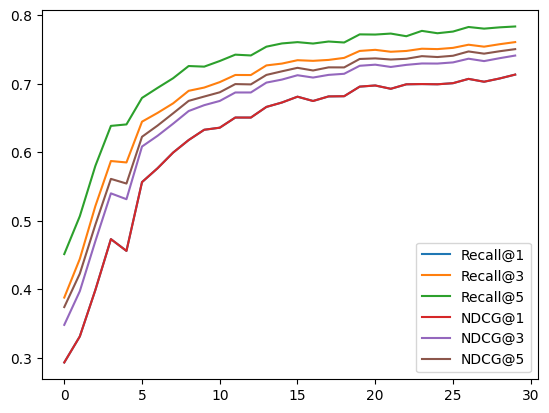

In [9]:
for i, key in enumerate(trainer.metrics.keys()): 
    index = list(range(len(trainer.metrics[key])))
    vals = trainer.metrics[key]
    plt.plot(index, vals, label = key)
    
plt.legend()
plt.show()

In [10]:
trainer.test()

Test best model with test set!


Val: N@1 0.669, N@3 0.699, N@5 0.709, R@1 0.669, R@3 0.720, R@5 0.744: 100%|██████████| 48/48 [00:11<00:00,  4.15it/s]

{'Recall@5': 0.7443033854166666, 'NDCG@5': 0.7089222657183806, 'Recall@3': 0.7198893229166666, 'NDCG@3': 0.6988641979793707, 'Recall@1': 0.6692382817467054, 'NDCG@1': 0.6692382817467054}
